# Identifying relationships between annotated omics data in NMDC

This notebook is an example of how different omics data types may be linked via commonly used annotation vocabularies and investigated together. In this notebook we explore biomolecules and KEGG pathways identified in a set of samples that have processed metagenomics, metaproteomics, and metabolomics data available in the NMDC Data Portal.

In [1]:
%%capture
## First need to install locally the nmdc_api_utilities
%pip install nmdc_api_utilities
%pip install Bio
%pip install pycirclize

## Set up environment variables
**You can disregard this section of code unless you have interest in testing this on the development API.**

Using pythons python-dotenv package, load the environment variables from the system. This chunk of code is used in the Github CI/CD pipelines to test our development API. The variable can be used when creating `nmdc_api_utilities` objects. If you do not have the environment variable `ENV` set in a .env file, this code with default to the variable "prod" - which tells nmdc_api_utilities to use the production API URL.

In [2]:
# set up environment variables
from dotenv import load_dotenv
import os
load_dotenv()
# load the environment variable ENV. If it does not exist, default to "prod"
ENV = os.environ.get("ENV", "prod")

In [3]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import numpy as np
import sys
from io import StringIO
from Bio.KEGG import REST
from pycirclize import Circos
import time
import importlib.util
import nmdc_api_utilities

# Identifying relationships between annotated omics data in NMDC

This notebook is an example of how different omics data types may be linked via commonly used annotation vocabularies and investigated together. In this notebook we explore biomolecules and KEGG pathways identified in a set of samples that have processed metagenomics, metaproteomics, and metabolomics data available in the NMDC Data Portal.

## 1. Retrieve data from the NMDC database using API endpoints

### Choose data to retrieve

The NMDC data portal (https://data.microbiomedata.org/) allows us to filter data and samples according to many criteria. In this case, we use the Data Type filters (the upset plot under the interactive map widget) to identify samples that have metagenomics, metaproteomics, and metabolomics data. This returns samples from the study "Riverbed sediment microbial communities from the Columbia River, Washington, USA" (https://data.microbiomedata.org/details/study/nmdc:sty-11-aygzgv51).

### Retrieve and filter data for Columbia River sediment study

The study page linked above has the NMDC study identifier in the URL: `nmdc:sty-11-aygzgv51`. We will use the [nmdc_api_utilities](https://microbiomedata.github.io/nmdc_api_utilities/) package to access the data_objects/study endpoint from the [NMDC Runtime API](https://api.microbiomedata.org/docs) to retrieve all records that represent data. This includes URLs for downloading raw data files (e.g. FASTQ or mass spectra files) as well as processed data results output by the NMDC workflows.

In [4]:
pd.set_option("display.max_rows", 6)
from nmdc_api_utilities.data_object_search import DataObjectSearch
do_client = DataObjectSearch(env=ENV)
#get all data objects associated with this study id
data = do_client.get_data_objects_for_studies(study_id='nmdc:sty-11-aygzgv51')
data = pd.DataFrame(data)

#reformat data into dataframe
data_objects=[]
for index, row in data.iterrows():
    bio_id = row['biosample_id']
    row_out = pd.json_normalize(row['data_objects'])
    row_out['biosample_id'] = bio_id
    data_objects.append(row_out)

data_objects = pd.concat(data_objects).reset_index(drop=True)
display(data_objects)

del data, index, row, row_out, bio_id

,id,type,name,description,file_size_bytes,md5_checksum,data_object_type,url,data_category,was_generated_by,in_manifest,alternative_identifiers,biosample_id
0,nmdc:dobj-11-3y8jwc91,nmdc:DataObject,nmdc_wfmgan-11-bnzfrb88.1_contig_names_mapping...,Contig mappings file for nmdc:wfmgan-11-bnzfrb...,14307334,20780518b9a17558a64e10e90a837caa,Contig Mapping File,https://data.microbiomedata.org/data/nmdc:ompr...,processed_data,NaN,NaN,NaN,nmdc:bsm-13-0jw5n594
1,nmdc:dobj-11-kfxwy785,nmdc:DataObject,nmdc_wfmag-11-2xsazh74.1_lq_bin.zip,Metagenome LQ Bins for nmdc:wfmag-11-2xsazh74.1,1544000,9977f033304125609ffea835d0613320,Metagenome LQ Bins Compression File,https://data.microbiomedata.org/data/nmdc:ompr...,processed_data,nmdc:wfmag-11-2xsazh74.1,NaN,NaN,nmdc:bsm-13-0jw5n594
2,nmdc:dobj-11-yj3yk998,nmdc:DataObject,nmdc_wfmag-11-2xsazh74.1_checkm_qa.out,CheckM for nmdc:wfmag-11-2xsazh74.1,785,bd388cba93a77cde2f5791fa0f580865,CheckM Statistics,https://data.microbiomedata.org/data/nmdc:ompr...,processed_data,nmdc:wfmag-11-2xsazh74.1,NaN,NaN,nmdc:bsm-13-0jw5n594
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4228,nmdc:dobj-11-pcxwpw86,nmdc:DataObject,Unground_SBR_Spring_2014_FC_N3_20-30_H2Oext_22...,EnviroMS processing parameters for natural org...,14118,3e91add00924c1c36134ef1b0dda4dad,Analysis Tool Parameter File,https://nmdcdemo.emsl.pnnl.gov/nom/stegen_11_a...,workflow_parameter_data,nmdc:wfnom-13-na9mkr50.2,NaN,NaN,nmdc:bsm-13-zq681s85
4229,nmdc:dobj-13-kay9ez18,nmdc:DataObject,Unground_SBR_Spring_2014_FC_N3_20-30_MeOHExt_2...,EnviroMS FT ICR-MS natural organic matter work...,74228,afc41e08ea7aba78e8fe3d3489db64c0,Direct Infusion FT-ICR MS Analysis Results,https://nmdcdemo.emsl.pnnl.gov/nom/results/Ung...,processed_data,nmdc:wfnom-13-1hkfpm05.1,NaN,NaN,nmdc:bsm-13-zq681s85
4230,nmdc:dobj-11-sdrnzd34,nmdc:DataObject,Unground_SBR_Spring_2014_FC_N3_20-30_MeOHExt_2...,EnviroMS QC plots representing a Direct Infusi...,437702,dd1d6777d35bc667c4eeb719dd5006ab,Direct Infusion FT-ICR MS QC Plots,https://nmdcdemo.emsl.pnnl.gov/nom/stegen_11_a...,processed_data,nmdc:wfnom-13-1hkfpm05.2,NaN,NaN,nmdc:bsm-13-zq681s85


One way of further identifying a NMDC `DataObject` record is by looking at its slot `data_object_type` (https://microbiomedata.github.io/nmdc-schema/data_object_type/), which contains a value from `FileTypeEnum` (https://microbiomedata.github.io/nmdc-schema/FileTypeEnum/). 

We want to look at the processed data results for our three omics types of interest in this notebook. Specifically, we want the files containing KEGG Orthology, KEGG Compound, and Enzyme Commission annotations. These annotations are available in separate files for the metagenomics data (in 'Annotation Enzyme Commission' and 'Annotation KEGG Orthology' data objects) and are found together in the metabolomics ('GC-Metabolomics Results') and metaproteomics ('Protein Report') results files.

We filter for results files with the following `data_object_type` values:

| Value | Description |
|:-----:|:-----------:|
|Annotation Enzyme Commission|Tab delimited file for EC annotation|
|Annotation KEGG Orthology|Tab delimited file for KO annotation|
|GC-MS Metabolomics Results|GC-MS-based metabolite assignment results table|
|Protein Report|Filtered protein report file|

In [5]:
# Filter to biosamples that have metagenome EC annotations, metagenome KO 
# annotations, metaproteomics results, and metabolomics results
data_objects = data_objects.groupby('biosample_id').filter(lambda x: all(data_type in x['data_object_type'].values for data_type in [
        "Annotation Enzyme Commission",
        "Annotation KEGG Orthology",
        "GC-MS Metabolomics Results",
        "Protein Report"
    ])).reset_index(drop=True).drop(columns=['alternative_identifiers', 'in_manifest'])

# Filter to the desired results file types
results_by_biosample = data_objects[data_objects['data_object_type'].isin([
    "Annotation Enzyme Commission", "Annotation KEGG Orthology",
    "GC-MS Metabolomics Results", "Protein Report"
])][['biosample_id', 'id','data_object_type', 'url']].rename(columns={'id':'output_id'}).reset_index(drop=True)

# Is there one output for each data object type for each biosample?
results_by_biosample['data_object_type'].value_counts().to_frame()

,count
data_object_type,
Protein Report,97
GC-MS Metabolomics Results,33
Annotation KEGG Orthology,33
Annotation Enzyme Commission,33


### Choose results by workflow version

Notice that `results_by_biosample` contains more than one `Protein Report` results file for some samples. When NMDC releases a new workflow version, existing data may be rerun, which means that multiple versions of the results are available. 

We will identify the versions of the results we want by looking up the corresponding `WorkflowExecution` records.

In [6]:
# Filter protein outputs to those associated with workflow v1.2.1 buy pulling the workflow records

# Define a function to split ids into chunks for the API query
def split_list(input_list, chunk_size=100):
    result = []
    
    for i in range(0, len(input_list), chunk_size):
        result.append(input_list[i:i + chunk_size])
        
    return result

#Instantiate instances for nmdc_api_utilities
from nmdc_api_utilities.workflow_execution_search import WorkflowExecutionSearch
from nmdc_api_utilities.data_processing import DataProcessing
# since we are querying the workflow collection, we need to create an instance of it
we_client = WorkflowExecutionSearch(env=ENV)
# create an instance of the data processing object
dp_client = DataProcessing()

# create a list of lists of ids to query workflow execution
chunked_list = split_list(results_by_biosample['output_id'].unique().tolist())
version_output = []
# loop through the chunked list of ids
for chunk in chunked_list:
    # create the filter - query the WorkflowExecutionSearch object looking for records
    filter_list = dp_client._string_mongo_list(chunk)
    filter = f'{{"has_output": {{"$in": {filter_list}}}}}'
    # get the results
    version_output += we_client.get_record_by_filter(filter=filter,fields="has_output,version", max_page_size=100, all_pages=True)


#normalize the json columns and merge
results_by_biosample = pd.json_normalize(version_output).rename(columns={'id':'workflow_id','version':'workflow_version'}).explode('has_output').drop_duplicates().merge(results_by_biosample, left_on='has_output',right_on='output_id').drop('has_output',axis=1)

results_by_biosample = results_by_biosample[['biosample_id','workflow_id','workflow_version','output_id','data_object_type','url']]

results_by_biosample = results_by_biosample[~(results_by_biosample['data_object_type'].str.contains('Protein Report', na=False) & ~results_by_biosample['workflow_version'].str.contains('v1.2.1',na=False))] # ~[condition] translates to keep rows where either both conditions are met or neither is met (Protein Report with v1.2.1 or its another type of report)

results_by_biosample

,biosample_id,workflow_id,workflow_version,output_id,data_object_type,url
1,nmdc:bsm-13-as680w10,nmdc:wfmgan-11-fk6zc010.1,v1.1.0,nmdc:dobj-11-mrpk2420,Annotation KEGG Orthology,https://data.microbiomedata.org/data/nmdc:ompr...
2,nmdc:bsm-13-as680w10,nmdc:wfmgan-11-fk6zc010.1,v1.1.0,nmdc:dobj-11-0j3myn58,Annotation Enzyme Commission,https://data.microbiomedata.org/data/nmdc:ompr...
3,nmdc:bsm-13-13145k83,nmdc:wfmgan-11-dvvh0237.1,v1.1.0,nmdc:dobj-11-0q21fa03,Annotation KEGG Orthology,https://data.microbiomedata.org/data/nmdc:ompr...
...,...,...,...,...,...,...
193,nmdc:bsm-13-peafgc08,nmdc:wfmb-13-4ymdss58.1,NaN,nmdc:dobj-13-s32awd29,GC-MS Metabolomics Results,https://nmdcdemo.emsl.pnnl.gov/metabolomics/re...
194,nmdc:bsm-13-mvpx4z13,nmdc:wfmb-13-z2dsr125.1,NaN,nmdc:dobj-13-w697k984,GC-MS Metabolomics Results,https://nmdcdemo.emsl.pnnl.gov/metabolomics/re...
195,nmdc:bsm-13-fs4zf767,nmdc:wfmb-13-94tgxz89.1,NaN,nmdc:dobj-13-z48fgm13,GC-MS Metabolomics Results,https://nmdcdemo.emsl.pnnl.gov/metabolomics/re...


### Download selected results files
 
Now we can use the `url` slot from the filtered `DataObject` records to read in all of the files containing the annotations of interest.

In [7]:
# Create one URL column per data type
results_by_biosample = results_by_biosample[['biosample_id', 'data_object_type', 'url']].pivot(
    index='biosample_id', 
    columns='data_object_type', 
    values='url'
).reset_index()

# Remove biosamples that don't have all omics types for the specified software versions
results_by_biosample = results_by_biosample.dropna(
    axis = 0, how = "any", subset = [
        "Annotation Enzyme Commission", "Annotation KEGG Orthology",
        "GC-MS Metabolomics Results", "Protein Report"])

# Function to read TSV files
def read_tsv_from_url(url:str, column_names:None):
    response = requests.get(url)
    if column_names is None:
        data = pd.read_csv(StringIO(response.text), sep='\t')
    else:
        data = pd.read_csv(StringIO(response.text), sep='\t', header=None, names=column_names)
    return data

# Function to read CSV files
def read_csv_from_url(url):
    response = requests.get(url)
    data = pd.read_csv(StringIO(response.text))
    return data

# Read EC results
ec_columns = ["gene_id", "img_ko_flag", "EC", "percent_identity",
              "query_start", "query_end", "subj_start", "subj_end",
              "evalue", "bit_score", "align_length"]

results_by_biosample['metag_ec_results'] = results_by_biosample['Annotation Enzyme Commission'].apply(
    lambda x: read_tsv_from_url(x, ec_columns) if pd.notnull(x) else None
)

# Read KO results
ko_columns = ["gene_id", "img_ko_flag", "ko_term", "percent_identity",
              "query_start", "query_end", "subj_start", "subj_end",
              "evalue", "bit_score", "align_length"]

results_by_biosample['metag_ko_results'] = results_by_biosample['Annotation KEGG Orthology'].apply(
    lambda x: read_tsv_from_url(x, ko_columns) if pd.notnull(x) else None
)


# Read Protein Report
results_by_biosample['metap_results'] = results_by_biosample['Protein Report'].apply(
    lambda x: read_tsv_from_url(url=x,column_names=None) if pd.notnull(x) else None
)


# Read GC-MS Metabolomics Results
results_by_biosample['metab_results'] = results_by_biosample['GC-MS Metabolomics Results'].apply(
    lambda x: read_csv_from_url(x) if pd.notnull(x) else None
)

results_by_biosample

data_object_type,biosample_id,Annotation Enzyme Commission,Annotation KEGG Orthology,GC-MS Metabolomics Results,Protein Report,metag_ec_results,metag_ko_results,metap_results,metab_results
0,nmdc:bsm-13-0jw5n594,https://data.microbiomedata.org/data/nmdc:ompr...,https://data.microbiomedata.org/data/nmdc:ompr...,https://nmdcdemo.emsl.pnnl.gov/metabolomics/re...,https://nmdcdemo.emsl.pnnl.gov/proteomics/resu...,ge...,g...,Data...,Sample name Peak I...
1,nmdc:bsm-13-13145k83,https://data.microbiomedata.org/data/nmdc:ompr...,https://data.microbiomedata.org/data/nmdc:ompr...,https://nmdcdemo.emsl.pnnl.gov/metabolomics/re...,https://nmdcdemo.emsl.pnnl.gov/proteomics/resu...,ge...,ge...,Data...,Sample name Peak I...
2,nmdc:bsm-13-1p0tct86,https://data.microbiomedata.org/data/nmdc:ompr...,https://data.microbiomedata.org/data/nmdc:ompr...,https://nmdcdemo.emsl.pnnl.gov/metabolomics/re...,https://nmdcdemo.emsl.pnnl.gov/proteomics/resu...,g...,gen...,Dat...,Sample name Peak ...
...,...,...,...,...,...,...,...,...,...
30,nmdc:bsm-13-xvf06c81,https://data.microbiomedata.org/data/nmdc:ompr...,https://data.microbiomedata.org/data/nmdc:ompr...,https://nmdcdemo.emsl.pnnl.gov/metabolomics/re...,https://nmdcdemo.emsl.pnnl.gov/proteomics/resu...,gene...,gene...,Dat...,Sample name Peak In...
31,nmdc:bsm-13-yjp2dx65,https://data.microbiomedata.org/data/nmdc:ompr...,https://data.microbiomedata.org/data/nmdc:ompr...,https://nmdcdemo.emsl.pnnl.gov/metabolomics/re...,https://nmdcdemo.emsl.pnnl.gov/proteomics/resu...,gene_id ...,g...,Dat...,Sample name Peak ...
32,nmdc:bsm-13-zms1jq91,https://data.microbiomedata.org/data/nmdc:ompr...,https://data.microbiomedata.org/data/nmdc:ompr...,https://nmdcdemo.emsl.pnnl.gov/metabolomics/re...,https://nmdcdemo.emsl.pnnl.gov/proteomics/resu...,gene...,g...,Dat...,Sample name Peak In...


Each of the downloaded data files contains detailed information including the KO, EC, or KEGG Compound identifiers.

In [8]:
# View a snippet of the metagenome KEGG Orthology annotations file
results_by_biosample['metag_ko_results'].iloc[0]

,gene_id,img_ko_flag,ko_term,percent_identity,query_start,query_end,subj_start,subj_end,evalue,bit_score,align_length
0,nmdc:wfmgan-11-bnzfrb88.1_000001_5389_7344,2794162845,KO:K03336,82.21,2,651,8,656,0.000000e+00,1210.0,650
1,nmdc:wfmgan-11-bnzfrb88.1_000001_7341_8171,2527268703,KO:K02510,78.12,13,268,11,265,7.400000e-139,453.0,256
2,nmdc:wfmgan-11-bnzfrb88.1_000001_12306_12872,2995783332,KO:K00010,78.31,1,189,5,193,5.000000e-104,345.0,189
...,...,...,...,...,...,...,...,...,...,...,...
100358,nmdc:wfmgan-11-bnzfrb88.1_208488_20_277,2843963262,KO:K01563,45.78,1,79,30,112,4.700000e-14,78.3,79
100359,nmdc:wfmgan-11-bnzfrb88.1_208592_3_146,2686680187,KO:K01938,87.23,1,47,514,560,2.500000e-22,97.7,47
100360,nmdc:wfmgan-11-bnzfrb88.1_208762_147_263,2946693089,KO:K00675,78.95,2,39,22,59,8.700000e-13,69.9,38


### Extract unique identifications

From each results table we can extract the unique list of genes/proteins/metabolites identified in that sample.

We also create a vector for each biomolecule containing all unique identifications across all samples, to simplify API calls later. 

In [9]:
# Metagenome annotations - KEGG Orthology
# Save a unique list of gene KO for each sample
results_by_biosample['metag_ko_unique'] = results_by_biosample['metag_ko_results'].apply(
    lambda x: sorted(x['ko_term'].dropna().unique(),key=str)
)


# Save a unique list of ALL gene KO for searching later (removing nas that will mess with chunked API calls)
metag_ko_unique = list(set(results_by_biosample['metag_ko_unique'].explode().dropna()))


# Metagenome annotations - Enzyme Commission
# Save a unique vector of gene EC by sample
results_by_biosample['metag_ec_unique'] = results_by_biosample['metag_ec_results'].apply(
    lambda x: sorted(x['EC'].dropna().unique(),key=str)
)

# Save a unique list of ALL gene EC for searching later
metag_ec_unique = list(set(results_by_biosample['metag_ec_unique'].explode().dropna()))


# Metaproteome annotations - KEGG Orthology
# Protein KO by sample
results_by_biosample['metap_ko_unique'] = results_by_biosample['metap_results'].apply(
    lambda x: sorted(x['KO'].dropna().unique(),key=str)
)

# ALL protein KO
metap_ko_unique = list(set(results_by_biosample['metap_ko_unique'].explode().dropna()))


# Metaproteome annotations - Enzyme Commission
# Protein EC by sample
results_by_biosample['metap_ec_unique'] = results_by_biosample['metap_results'].apply(
    lambda x: sorted(x['EC_Number'].dropna().str.split(',').explode().unique(),key=str)
)

# ALL protein EC
metap_ec_unique = list(set(results_by_biosample['metap_ec_unique'].explode().dropna()))


# Dataframe of metaproteome annotations across all samples
# Keep KO and EC results together
metap_combined_unique = pd.concat(results_by_biosample['metap_results'].tolist(), ignore_index=True)[['KO','EC_Number']].rename(columns = {'EC_Number':'ec_id', 'KO':'ko_id'})

# EC column may have multiple comma separated values
# Reform dataframe to have one EC per row
metap_combined_unique['ec_id'] = metap_combined_unique['ec_id'].str.split(',')
metap_combined_unique = metap_combined_unique.explode('ec_id').reset_index(drop=True).drop_duplicates()

# Remove rows that are all NA
metap_combined_unique.dropna(how='all',inplace=True)

# If KO id is present in more than one row, once with a mapping EC id and once with NA, remove the NA row

# Identify ko ids in more than one row
duplicate = metap_combined_unique['ko_id'].duplicated(keep=False)

# Remove the rows with NA values in ec_id for those groups present more than once
metap_combined_unique = metap_combined_unique[~(duplicate & metap_combined_unique['ec_id'].isna())]


# Metabolome annotations - KEGG Compound
# Compound IDs per sample (added white space removal because one CO had \t)
results_by_biosample['metab_co_unique'] = results_by_biosample['metab_results'].apply(
    lambda x: sorted(x['Kegg Compound ID'].dropna().str.strip().unique(),key=str)
)

# ALL compound IDs
metab_co_unique = list(set(results_by_biosample['metab_co_unique'].explode().dropna()))

results_by_biosample


data_object_type,biosample_id,Annotation Enzyme Commission,Annotation KEGG Orthology,GC-MS Metabolomics Results,Protein Report,metag_ec_results,metag_ko_results,metap_results,metab_results,metag_ko_unique,metag_ec_unique,metap_ko_unique,metap_ec_unique,metab_co_unique
0,nmdc:bsm-13-0jw5n594,https://data.microbiomedata.org/data/nmdc:ompr...,https://data.microbiomedata.org/data/nmdc:ompr...,https://nmdcdemo.emsl.pnnl.gov/metabolomics/re...,https://nmdcdemo.emsl.pnnl.gov/proteomics/resu...,ge...,g...,Data...,Sample name Peak I...,"[KO:K00001, KO:K00003, KO:K00004, KO:K00008, K...","[EC:1.-, EC:1.1.-, EC:1.1.1.-, EC:1.1.1.1, EC:...","[KO:K01607, KO:K01992, KO:K01999, KO:K02058, K...","[EC:1.8.3.7, EC:3.4.21.-, EC:4.1.1.44, EC:7.4....","[C00009, C00013, C00016, C00025, C00026, C0003..."
1,nmdc:bsm-13-13145k83,https://data.microbiomedata.org/data/nmdc:ompr...,https://data.microbiomedata.org/data/nmdc:ompr...,https://nmdcdemo.emsl.pnnl.gov/metabolomics/re...,https://nmdcdemo.emsl.pnnl.gov/proteomics/resu...,ge...,ge...,Data...,Sample name Peak I...,"[KO:K00001, KO:K00002, KO:K00003, KO:K00004, K...","[EC:1.-, EC:1.1.-, EC:1.1.1.-, EC:1.1.1.1, EC:...","[KO:K00368, KO:K00958, KO:K01996, KO:K02058, K...","[EC:1.20.4.4, EC:1.7.2.1, EC:2.7.7.4, EC:6.5.1.8]","[C00009, C00013, C00026, C00037, C00041, C0004..."
2,nmdc:bsm-13-1p0tct86,https://data.microbiomedata.org/data/nmdc:ompr...,https://data.microbiomedata.org/data/nmdc:ompr...,https://nmdcdemo.emsl.pnnl.gov/metabolomics/re...,https://nmdcdemo.emsl.pnnl.gov/proteomics/resu...,g...,gen...,Dat...,Sample name Peak ...,"[KO:K00001, KO:K00003, KO:K00004, KO:K00008, K...","[EC:1.-, EC:1.1.-, EC:1.1.1.-, EC:1.1.1.1, EC:...","[KO:K00023, KO:K00077, KO:K00114, KO:K00138, K...","[EC:1.1.1.169, EC:1.1.1.36, EC:1.1.2.10, EC:1....","[C00009, C00013, C00016, C00020, C00026, C0003..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,nmdc:bsm-13-xvf06c81,https://data.microbiomedata.org/data/nmdc:ompr...,https://data.microbiomedata.org/data/nmdc:ompr...,https://nmdcdemo.emsl.pnnl.gov/metabolomics/re...,https://nmdcdemo.emsl.pnnl.gov/proteomics/resu...,gene...,gene...,Dat...,Sample name Peak In...,"[KO:K00001, KO:K00003, KO:K00004, KO:K00005, K...","[EC:1.-, EC:1.1.-, EC:1.1.1.-, EC:1.1.1.1, EC:...","[KO:K00113, KO:K00114, KO:K00124, KO:K00244, K...","[EC:1.1.2.10, EC:1.1.2.8, EC:1.11.1.24, EC:1.1...","[C00013, C00016, C00041, C00047, C00049, C0005..."
31,nmdc:bsm-13-yjp2dx65,https://data.microbiomedata.org/data/nmdc:ompr...,https://data.microbiomedata.org/data/nmdc:ompr...,https://nmdcdemo.emsl.pnnl.gov/metabolomics/re...,https://nmdcdemo.emsl.pnnl.gov/proteomics/resu...,gene_id ...,g...,Dat...,Sample name Peak ...,"[KO:K00001, KO:K00003, KO:K00004, KO:K00008, K...","[EC:1.-, EC:1.1.-, EC:1.1.1.-, EC:1.1.1.1, EC:...","[KO:K00027, KO:K00031, KO:K00033, KO:K00059, K...","[EC:1.1.1.-, EC:1.1.1.100, EC:1.1.1.291, EC:1....","[C00009, C00013, C00016, C00020, C00025, C0002..."
32,nmdc:bsm-13-zms1jq91,https://data.microbiomedata.org/data/nmdc:ompr...,https://data.microbiomedata.org/data/nmdc:ompr...,https://nmdcdemo.emsl.pnnl.gov/metabolomics/re...,https://nmdcdemo.emsl.pnnl.gov/proteomics/resu...,gene...,g...,Dat...,Sample name Peak In...,"[KO:K00001, KO:K00003, KO:K00004, KO:K00005, K...","[EC:1.-, EC:1.1.-, EC:1.1.1.-, EC:1.1.1.1, EC:...","[KO:K00008, KO:K00362, KO:K00368, KO:K00518, K...","[EC:1.1.1.14, EC:1.1.1.47, EC:1.1.2.10, EC:1.1...","[C00009, C00013, C00016, C00025, C00042, C0004..."


## 2. Use annotations in file output to link identifications

Metagenomic and metaproteomic results in NMDC already have both KEGG Orthology and Enzyme Commission annotations which can be used to link gene and protein identifications without any additional information from KEGG. 

The plot below is a simple example of how to start associating the gene/protein results by counting the number of metagenomic KO annotations that also appear in the metaproteomic results.

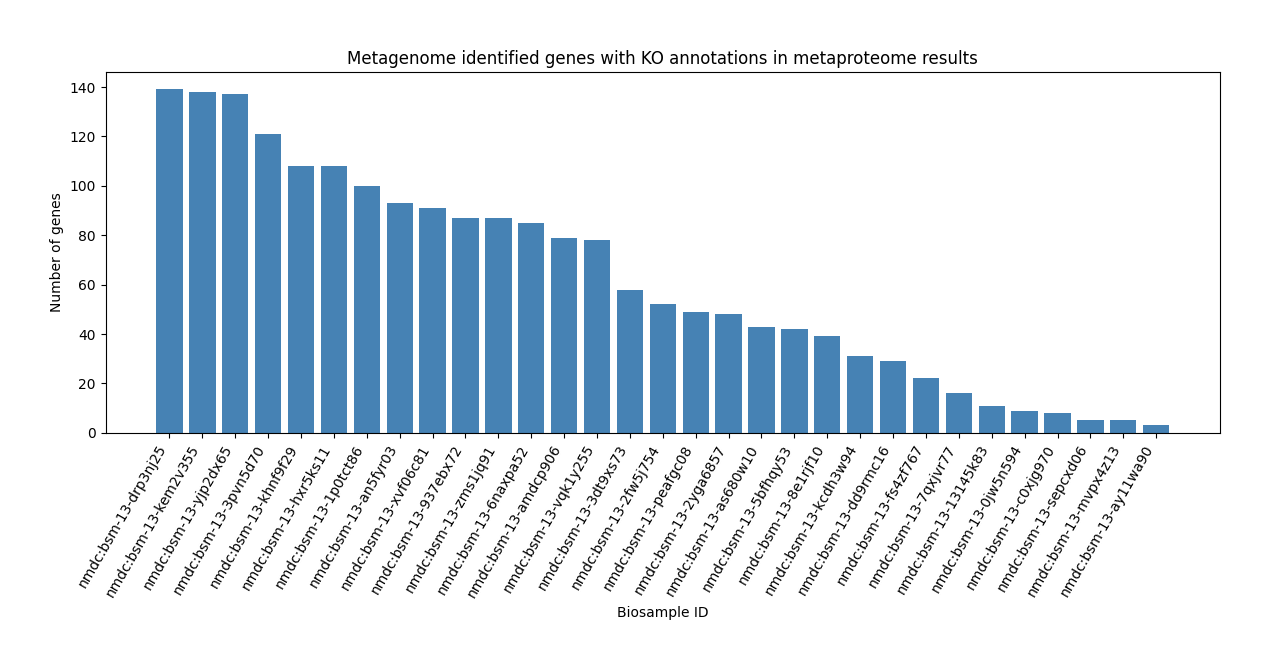

In [10]:
# For each sample, check which metagenomic KO results also appear in the metaproteomic KO results
for index, row in results_by_biosample.iterrows():
    metag_ko_unique_list = row['metag_ko_unique']
    metap_ko_unique_list = row['metap_ko_unique']
    results_by_biosample.at[index,'genes_w_protein'] = len([value for value in metag_ko_unique_list if value in metap_ko_unique_list])

results_by_biosample = results_by_biosample.sort_values('genes_w_protein', ascending=False).reset_index(drop=True)

plt.figure(figsize=(12, 6))
plt.bar(results_by_biosample['biosample_id'], results_by_biosample['genes_w_protein'], color='steelblue')
plt.title("Metagenome identified genes with KO annotations in metaproteome results")
plt.xlabel("Biosample ID")
plt.ylabel("Number of genes")
plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()


The rest of this notebook uses the KEGG API to retrieve additional information for identified biomolecules, which enables more multi-omic analysis and provides more context for their biological relevance. Use of the KEGG API is restricted to academic users or commercial license holders (see [Licensing Information](##-Licensing-Information)).

## 3. Get IDs from other KEGG databases

Now we will use the KEGGREST package (available on Biopython) to make calls to the KEGG API. Using the annotations provided in the NMDC results files, we can look up their corresponding annotations in KEGG databases to start drawing connections between biomolecule identifications. 

For example, in the first use of `REST.keggLink()` below, we are searching the KEGG ENZYME database for Enzyme Commission numbers that are _linked_ to each KEGG Compound ID in the character list `metab_co_unique`.

We will also search for linked KEGG modules and pathways. KEGG pathways are manually drawn maps that represent all the reactions in a biological process and are typically composed of a number of more discrete functional units, the KEGG modules.

Notes:
- `keggLink()` calls are paired with a 0.5s `time.sleep()` command. This is to limit the number of API calls we are making per second to avoid overloading the KEGG REST API and having API calls rejected.
- Character lists of IDs to query are broken up into 50-element pieces to avoid overly long HTTP request URLs.

### Gather metabolite information

First we will find all of the Enzyme Commission numbers available for each compound identified in the metabolomics results. These EC numbers represent enzymes that catalyze reactions involving the compound of interest.

In [12]:
# Define function to get IDs for a certain KEGG database
def get_ids(compounds,database):
    time.sleep(0.5)
    dict = {}
    return_string = REST.kegg_link(database, compounds).read()
    strings = return_string.strip().split('\n')
    for string in strings:
        if string:
            key, value = string.split('\t')
            if key in dict:
                dict[key].append(value)
            else:
                dict[key] = [value]
    return dict

# get EC ids for each metabolite CO 
ec_from_metabolites = {}
for i in range(0, len(metab_co_unique), 50):
    chunk = metab_co_unique[i:i+50]
    ec_from_metabolites.update(get_ids(chunk,'enzyme'))

# Format into a dataframe
ec_from_metabolites = pd.DataFrame({
    'compound_id': list(ec_from_metabolites.keys()),
    'ec_id': list(ec_from_metabolites.values())
})

display(ec_from_metabolites)

URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)>

Then we will do the same to pull all of the modules and pathways that each compound is a part of. 

In [ ]:
modules_from_metabolites = {}
for i in range(0, len(metab_co_unique), 50):
    chunk = metab_co_unique[i:i+50]
    modules_from_metabolites.update(get_ids(chunk,'module'))

# Format into a dataframe
modules_from_metabolites = pd.DataFrame({
    'compound_id': list(modules_from_metabolites.keys()),
    'module_id': list(modules_from_metabolites.values())
})

pathways_from_metabolites = {}
for i in range(0, len(metab_co_unique), 50):
    chunk = metab_co_unique[i:i+50]
    pathways_from_metabolites.update(get_ids(chunk,'pathway'))

# Format into a dataframe
pathways_from_metabolites = pd.DataFrame({
    'compound_id': list(pathways_from_metabolites.keys()),
    'pathway_id': list(pathways_from_metabolites.values())
})

Join the results to produce a dataframe containing EC, module, and pathway IDs for each metabolite identified across all samples.

In [ ]:
# Create the initial dataframe
metabolite_annotations = pd.DataFrame({
    'compound_id': [f'cpd:{id}' for id in metab_co_unique],
    'compound_trimmed': metab_co_unique
})

#merge
metabolite_annotations = (metabolite_annotations
                          .merge(ec_from_metabolites, on='compound_id', how='left')
                          .merge(modules_from_metabolites, on='compound_id', how='left')
                          .merge(pathways_from_metabolites, on='compound_id', how='left')
                         )

display(metabolite_annotations)

Finally, use a filtering join on the list of metabolite identifications per biosample and the list of all metabolite annotations to create a list of dataframes containing all annotations per biosample.

In [ ]:
#initialize new column that will store metabolite annotation info for sample
results_by_biosample['metab_df'] = None

for index, row in results_by_biosample.iterrows():

    # For each sample, assemble a dataframe of metabolite information
    # Start with the unique list of metabolites for this sample
    metab_info = pd.DataFrame({'compound_id':[f"cpd:{cpd}" for cpd in row['metab_co_unique']]})

    # Filter join all metabolite annotations down to just the ones in this sample
    metab_info = metab_info.merge(
        metabolite_annotations, 
        on='compound_id', 
        how='left'
    )

    #save dataframe into new column of df
    results_by_biosample.at[index,'metab_df'] = metab_info

# Display one example dataframe
display(results_by_biosample.iloc[0]['metab_df'])

### Gather protein information

Next we will do the same thing for proteins in each sample - starting with the KO and EC IDs from the NMDC annotation workflow, identify the modules and pathways each protein is associated with, and what corresponding metabolites/genes were identified in this sample.

In [ ]:
# Use concatenated proteins vector, make all the calls once, then split up by biosample

# Get all module ids for each protein
modules_from_proteins = {}
for i in range(0, len(metap_ko_unique), 50):
    chunk = metap_ko_unique[i:i+50]
    ## API doesn't like the prefix in the annotated results, trim it off
    chunk = [item.split(':')[1] for item in chunk if isinstance(item, str)]
    modules_from_proteins.update(get_ids(chunk,'module'))

# Format into a dataframe
modules_from_proteins = pd.DataFrame({
    'ko_id': list(modules_from_proteins.keys()),
    'module_id': list(modules_from_proteins.values())
})

# Convert 'ko_id' to uppercase
modules_from_proteins['ko_id'] = modules_from_proteins['ko_id'].str.upper()

# Get all pathway ids for each protein
pathways_from_proteins = {}
for i in range(0, len(metap_ko_unique), 50):
    chunk = metap_ko_unique[i:i+50]
    chunk = [item.split(':')[1] for item in chunk if isinstance(item, str)]
    pathways_from_proteins.update(get_ids(chunk,'pathway'))

# Format into a dataframe
pathways_from_proteins = pd.DataFrame({
    'ko_id': list(pathways_from_proteins.keys()),
    'pathway_id': list(pathways_from_proteins.values())
})

# Convert 'ko_id' to uppercase
pathways_from_proteins['ko_id'] = pathways_from_proteins['ko_id'].str.upper()

# Assemble, starting from the dataframe of joined KO/EC annotations from the Protein Report
protein_annotations = (metap_combined_unique
                       .merge(modules_from_proteins,on='ko_id',how='left')
                       .merge(pathways_from_proteins,on='ko_id',how='left')
                       )

#initialize new column that will store protein annotation info for sample
results_by_biosample['prot_info'] = None

# Create column for protein dataframes
for index, row in results_by_biosample.iterrows():

    # For each sample, assemble a dataframe of protein information
    # Start with the unique list of proteins for this sample
    prot_info = (pd.DataFrame({'ko_id':row['metap_ko_unique']})
                  # Filter join all protein annotations down to just the ones in this sample
                  .merge(protein_annotations, on='ko_id', how='left'))

    #save dataframe into new column of df
    results_by_biosample.at[index,'prot_info'] = prot_info

# Display one example dataframe
display(results_by_biosample.iloc[0]['prot_info'])

### Gather gene information

Finally we will find modules and pathways for each gene and create the same list of dataframes for the metagenomes in each sample.

In [ ]:
# Use concatenated metag KO vector, make all the calls once, then split up by biosample

# Get all module ids for each gene
modules_from_genes = {}
for i in range(0, len(metag_ko_unique), 50):
    chunk = metag_ko_unique[i:i+50]
    ## API doesn't like the prefix in the annotated results, trim it off
    chunk = [item.split(':')[1] for item in chunk if isinstance(item, str)]
    modules_from_genes.update(get_ids(chunk,'module'))

# Format into a dataframe
modules_from_genes = pd.DataFrame({
    'ko_id': list(modules_from_genes.keys()),
    'module_id': list(modules_from_genes.values())
})

# Convert 'ko_id' to uppercase
modules_from_genes['ko_id'] = modules_from_genes['ko_id'].str.upper()


# Get all pathway ids for each gene
pathways_from_genes = {}
for i in range(0, len(metag_ko_unique), 50):
    chunk = metag_ko_unique[i:i+50]
    chunk = [item.split(':')[1] for item in chunk if isinstance(item, str)]
    pathways_from_genes.update(get_ids(chunk,'pathway'))

# Format into a dataframe
pathways_from_genes = pd.DataFrame({
    'ko_id': list(pathways_from_genes.keys()),
    'pathway_id': list(pathways_from_genes.values())
})

# Convert 'ko_id' to uppercase
pathways_from_genes['ko_id'] = pathways_from_genes['ko_id'].str.upper()


# Assemble
gene_annotations = (pd.DataFrame({'ko_id' : metag_ko_unique})
                    .merge(modules_from_genes, on='ko_id',how='left')
                    .merge(pathways_from_genes, on='ko_id',how='left')
                    )

gene_annotations


The metagenome results have KO and EC IDs in different annotation files, as we saw above when reading in results files. Join the EC IDs to the KO IDs here.

There is a filter applied in this step to only retain genes that have EC IDs. This is because there are more gene identifications than there are proteins and metabolites, and for this notebook we want to focus on the genes that could potentially be linked to proteins or metabolites by their EC ID. This affects downstream pathway coverage counts.

In [ ]:
#initialize new column that will store gene annotation info for sample
results_by_biosample['gene_info'] = None

# Create column for metagenome dataframes
for index, row in results_by_biosample.iterrows():

    # For each sample, assemble a dataframe of combined KO and EC gene information
    gene_info = (row['metag_ko_results'][['gene_id','ko_term']]
                  .merge(row['metag_ec_results'][['gene_id','EC']], on='gene_id', how='outer')
                  [['ko_term','EC']]
                  .drop_duplicates()
                  .reset_index(drop=True)
                  .rename(columns={'ko_term':'ko_id','EC':'ec_id'}))

    # Filter to only KO identifications that also have EC information
    gene_info = gene_info.dropna(subset=['ec_id'])

    # Now filter join all gene annotations down to just the ones in this sample
    gene_info = gene_info.merge(gene_annotations, on='ko_id',how='left')

    #save dataframe into new column of df
    results_by_biosample.at[index,'gene_info'] = gene_info


# Display one example dataframe
display(results_by_biosample.iloc[0]['gene_info'])

### Identify linked IDs between biosamples

We can now check which biomolecules have linked annotations in the other two omics types (for example, checking whether each metabolite has a linked annotation in the metagenomic and metaproteomic results).

The code below iterates through samples and adds two columns in each annotation dataframe labelling whether that molecule has a linked annotation among the other two omics types for that sample. 

In [ ]:
def x_in_y_or_z(data_x, data_y, data_z, column, y_named_output, z_named_output):
    
    # Ensure columns exist and are of object dtype to allow bool/nan assignment
    for col in [y_named_output, z_named_output]:
        if col not in data_x.columns:
            data_x[col] = np.nan
        data_x[col] = data_x[col].astype(object)


    for x_index, x_row in data_x.iterrows():

        #if data_x's column value is not a float/NAN
        if not isinstance(x_row[column], float):
            
            #make the ids being compared a lowercase list to iterate through
            x_ids = pd.Series(x_row[column]).dropna().str.lower().tolist()

            #make the ids to compare to collapsed lower case lists
            all_y_ids = (data_y[column]
                           .explode()
                            .dropna().str.lower().tolist())
            all_z_ids = (data_z[column]
                           .explode()
                            .dropna().str.lower().tolist())

            #determine if there are any ids in this row of data_x that match data_y or data_z
            In_Y_Annotations = any(element in x_ids for element in all_y_ids)
            In_Z_Annotations = any(element in x_ids for element in all_z_ids)

        else:
            #if data_x's column value is a float/nan then assign it such
            In_Y_Annotations = np.nan
            In_Z_Annotations = np.nan

        #save new columns to metab_df
        data_x.at[x_index,y_named_output] = In_Y_Annotations
        data_x.at[x_index,z_named_output] = In_Z_Annotations
    
    return data_x

In [ ]:
# Add "is this x in y" columns for all biomolecules

for sample_index, sample_row in results_by_biosample.iterrows():
    
    #metabolite, gene and protein info for this biosample
    metab_df = sample_row['metab_df']
    gene_info = sample_row['gene_info']
    prot_info = sample_row['prot_info']

    #indicate whether one of metabolite's ec id(s) in this biosample is also in the biosample's metagenome and/or metaproteome results
    metab_df = x_in_y_or_z(metab_df, gene_info, prot_info, 'ec_id', 'In_Metag_Annotations', 'In_Metap_Annotations')
    results_by_biosample.at[sample_index,'metab_df'] = metab_df

    #indicate whether each protein's ec id(s) in this biosample are also in the biosample's metabolome and/or metagenome results
    prot_info = x_in_y_or_z(prot_info, metab_df, gene_info, 'ec_id', 'In_Metab_Annotations', 'In_Metag_Annotations')
    results_by_biosample.at[sample_index,'prot_info'] = prot_info

    #indicate whether each gene's ec id(s) in this biosample are also in the biosample's metabolome and/or metaproteome results
    gene_info = x_in_y_or_z(gene_info, metab_df, prot_info, 'ec_id', 'In_Metab_Annotations', 'In_Metap_Annotations')
    results_by_biosample.at[sample_index,'gene_info'] = gene_info


display(results_by_biosample.iloc[0]['metab_df'])
display(results_by_biosample.iloc[0]['prot_info'])
display(results_by_biosample.iloc[0]['gene_info'])

## 4. Visualize shared biomolecule identifications

The [pyCirclize](https://moshi4.github.io/pyCirclize/) package enables construction of circular diagrams with arcs between sectors showing relationships between multiple groups. We will use `pyCirclize` to create a chord diagram showing where the annotations from the metagenomic, metaproteomic, and metabolomic results link to each other. 

First, choose a biosample from the list to visualize. Then use its gathered annotations to calculate the sectors and arcs needed for the plot. There will be three sectors representing genes, proteins, and metabolites, then three arcs connecting the pairs of sectors.

In [ ]:
# Select an example biosample
example_genes = results_by_biosample['gene_info'].iloc[0]
example_prot = results_by_biosample['prot_info'].iloc[0]
example_metab = results_by_biosample['metab_df'].iloc[0]

# Scale sectors so that arc widths are proportional rather than absolute for better visualization
largest_sector_xlim = max(len(example_genes['ko_id'].unique()),
                          len(example_prot['ko_id'].unique()),
                          len(example_metab['compound_id'].unique()))

# Gene sector
# Calculate size of sector
gene_sector_xlim = len(example_genes['ko_id'].unique())

# Sum the number of genes that show up in the protein annotations, then scale
gene_sector_prot_count = ((example_genes[['ko_id', 'In_Metap_Annotations']].drop_duplicates())['In_Metap_Annotations'].sum()) * (largest_sector_xlim / gene_sector_xlim)
# Sum the number of genes that show up in protein AND metabolite annotations, then scale
gene_sector_both_count = example_genes.groupby('ko_id').apply(lambda x: (x['In_Metab_Annotations'].any() & x['In_Metap_Annotations'].any()), include_groups=False).sum() * (largest_sector_xlim / gene_sector_xlim)
# Sum the number of genes that show up in metabolite annotations, then scale
gene_sector_metab_count = ((example_genes[['ko_id', 'In_Metab_Annotations']].drop_duplicates())['In_Metab_Annotations'].sum()) * (largest_sector_xlim / gene_sector_xlim)

# Prot sector
prot_sector_xlim = len(example_prot['ko_id'].unique())

prot_sector_metab_count = ((example_prot[['ko_id', 'In_Metab_Annotations']].drop_duplicates())['In_Metab_Annotations'].sum()) * (largest_sector_xlim / prot_sector_xlim)
prot_sector_both_count = example_prot.groupby('ko_id').apply(lambda x: (x['In_Metab_Annotations'].any() & x['In_Metag_Annotations'].any()), include_groups=False).sum() * (largest_sector_xlim / prot_sector_xlim)
prot_sector_gene_count = ((example_prot[['ko_id', 'In_Metag_Annotations']].drop_duplicates())['In_Metag_Annotations'].sum()) * (largest_sector_xlim / prot_sector_xlim)

# Metab sector
metab_sector_xlim = len(example_metab['compound_id'].unique())

metab_sector_gene_count = ((example_metab[['compound_id', 'In_Metag_Annotations']].drop_duplicates())['In_Metag_Annotations'].sum())  * (largest_sector_xlim / metab_sector_xlim)
metab_sector_both_count = example_metab.groupby('compound_id').apply(lambda x: (x['In_Metap_Annotations'].any() & x['In_Metag_Annotations'].any()), include_groups=False).sum() * (largest_sector_xlim / metab_sector_xlim)
metab_sector_prot_count = ((example_metab[['compound_id', 'In_Metap_Annotations']].drop_duplicates())['In_Metap_Annotations'].sum()) * (largest_sector_xlim / metab_sector_xlim)

# Reset sector sizes to scaled value
gene_sector_xlim = largest_sector_xlim
prot_sector_xlim = largest_sector_xlim
metab_sector_xlim = largest_sector_xlim

Now use the calculated sectors/arcs to generate the chord diagram.

In [ ]:
# Initialize circos sectors
sectors = {"genes":gene_sector_xlim, "proteins":prot_sector_xlim, "metabolites":metab_sector_xlim}
colors = {"genes": "tomato", "proteins": "gold", "metabolites": "skyblue"}
counts = {"genes":len(example_genes), "proteins":len(example_prot), "metabolites":len(example_metab)}
circos = Circos(sectors, space=3)

# add track for sector colors in outer ring
for sector in circos.sectors:
    track = sector.add_track((75, 100))
    track.axis(fc=colors[sector.name])
    track.text(f"{sector.name} ({counts[sector.name]})", size=15)
    #track.xticks_by_interval(200)

# add links between sectors
circos.link(
    # Create a link that starts at the beginning of the gene sector
    # It is as wide as the scaled number of gene/protein shared annotations (see above)
    ("genes", 0, gene_sector_prot_count),

    # The other end of the link is in the protein sector
    # It starts at the number of protein/metabolite but NOT gene shared annotations
    # It is as wide as the scaled number of gene/protein shared annotations
    ("proteins", prot_sector_metab_count - prot_sector_both_count,
     prot_sector_metab_count - prot_sector_both_count + prot_sector_gene_count),
    color="#ff870099")


# Repeat for metab/genes
circos.link(
    ("metabolites", 0, metab_sector_gene_count),
    ("genes", gene_sector_prot_count - gene_sector_both_count,
    gene_sector_prot_count - gene_sector_both_count + gene_sector_metab_count),
    color="#8b24cd99")


# Repeat for proteins/metab
circos.link(
    ("proteins", 0, prot_sector_metab_count),
    ("metabolites", metab_sector_gene_count - metab_sector_both_count,
    metab_sector_gene_count - metab_sector_both_count + metab_sector_prot_count),
    color="#63ff0099")
  
    
circos.plotfig()
plt.show()

In the chord diagram, each arc is showing what proportion of identified biomolecules have a linked annotation in the identified biomolecules on the other end of the arc. For example, the purple arc shows that about a third of the genes have a link to a compound ID that was identified in the metabolomics data for this sample. 

Areas where the ends of two arcs overlap (e.g., the green and orange arc ends at the bottom of the protein sector) indicate that those molecules have corresponding identified biomolecules in all three data types.

## 5. Calculate coverage of KEGG pathways across samples

Assemble a list of all of the pathway IDs that any biomolecules in each sample map to (obtained from API calls earlier).
The KEGG API returns duplicate IDs for each pathway, one that is blank, and one that has all of the KO elements highlighted. Exclude the highlighted maps from the list for redundancy.
Some of the maps are "overview" maps which encompass an enormous number of metabolic reactions, to the point that it is not especially informative if a compound maps to one. Exclude those pathways as well. (See https://www.genome.jp/kegg/pathway.html#global) 

In [ ]:
#initialize new column that will store all pathways ids for each biosample
results_by_biosample['pathways'] = None

# Create column for metagenome dataframes
for index, row in results_by_biosample.iterrows():

    # Get unique list of pathways from all identified biomolecules
    genes = row['gene_info']['pathway_id'].explode().drop_duplicates().dropna().unique().tolist()
    proteins = row['prot_info']['pathway_id'].explode().drop_duplicates().dropna().unique().tolist()
    metabolites = row['metab_df']['pathway_id'].explode().drop_duplicates().dropna().unique().tolist()
    sample_pathways = genes + metabolites + proteins

    # Look at basic pathway maps, exclude KO highlighted pathway maps
    sample_pathways = [item for item in sample_pathways if 'path:ko' not in item]

    # Exclude "overview" pathway maps
    sample_pathways = [item for item in sample_pathways if 'path:map01' not in item]

    results_by_biosample.at[index,'pathways'] = sample_pathways


Now, using the complete list of pathways, make one more set of API calls to obtain the full list of compounds and KO elements found in that pathway. In this case we are only searching for KO and compound IDs, EC IDs in pathways just point to the corresponding KO element.

There is a filter applied in this step that retains pathways with at least one gene and at least one compound. Some KEGG pathways have all KO/EC elements or all compounds and in this notebook we want to examine pathways that have both.

In [ ]:
pathway_ids = list(set(results_by_biosample['pathways'].explode().dropna()))

# get compound ids for each pathway id
compounds_from_pathways = {}
for i in range(0, len(pathway_ids), 50):
    chunk = pathway_ids[i:i+50]
    compounds_from_pathways.update(get_ids(chunk,'compound'))

# Format into a dataframe
compounds_from_pathways = pd.DataFrame({
    'pathway_id': list(compounds_from_pathways.keys()),
    'compound_id': list(compounds_from_pathways.values())
})

# Get all KO for each pathway
ko_from_pathways = {}
for i in range(0, len(pathway_ids), 50):
    chunk = pathway_ids[i:i+50]
    ko_from_pathways.update(get_ids(chunk,'ko'))

# Format into a dataframe
ko_from_pathways = pd.DataFrame({
    'pathway_id': list(ko_from_pathways.keys()),
    'ko_id': list(ko_from_pathways.values())
})

# Combine KO and compound ids for each pathway
all_pathway_elements = compounds_from_pathways.merge(ko_from_pathways, how='outer', on='pathway_id')

# Count number of compound and ko ids for each pathway
all_pathway_elements['compound_count'] = None
all_pathway_elements['ko_count'] = None
for index, row in all_pathway_elements.iterrows():

    if isinstance(row['compound_id'],float) and np.isnan(row['compound_id']):
        all_pathway_elements.at[index,'compound_count'] = 0
    else:
        all_pathway_elements.at[index,'compound_count'] =  len(row['compound_id'])

    
    if isinstance(row['ko_id'],float) and np.isnan(row['ko_id']):
        all_pathway_elements.at[index,'ko_count'] =  0
    else:
        all_pathway_elements.at[index,'ko_count'] =  len(row['ko_id'])

#count total
all_pathway_elements['total_elements'] = None
all_pathway_elements['total_elements'] = all_pathway_elements['compound_count'] + all_pathway_elements['ko_count']

all_pathway_elements

Now we will calculate the "coverage" of each KEGG pathway found in each biosample by simply dividing the number of biomolecules that were found in the omics data by the total number of elements in the pathway.

In [ ]:
#initialize new column that will store all pathways ids for each biosample
results_by_biosample['pathway_coverage'] = None

# Create column for metagenome dataframes
for sample_index, sample_row in results_by_biosample.iterrows():

    #all ko ids in biosample
    all_ko_detected = list(set(list(sample_row['gene_info']['ko_id'].dropna().str.upper()) + list(sample_row['prot_info']['ko_id'].dropna().str.upper())))

    #information for pathways in this biosample
    pathway_coverage = all_pathway_elements[all_pathway_elements['pathway_id'].isin(sample_row['pathways'])].copy()

    #biosample's metabolite compound ids
    metab_cpids = sample_row['metab_df']['compound_id'].tolist()

    pathway_coverage['compound_found'] = int
    pathway_coverage['compound_coverage'] = int
    pathway_coverage['ko_found'] = int
    pathway_coverage['ko_coverage'] = int
    
    for path_index, path_row in pathway_coverage.iterrows():
        
        #pathway's compound ids
        path_cpids = path_row['compound_id']

        #pathway's ko ids
        path_koids = path_row['ko_id']

        if isinstance(path_cpids,float) and np.isnan(path_cpids):
            pathway_coverage.at[path_index,'compound_found'] = 0
            pathway_coverage.at[path_index,'compound_coverage'] = 0
        else:
            compound_found = len([item for item in path_cpids if item in metab_cpids])
            pathway_coverage.at[path_index,'compound_found'] = compound_found
            pathway_coverage.at[path_index,'compound_coverage'] = compound_found / path_row['compound_count']

        if isinstance(path_koids,float) and np.isnan(path_koids):
            pathway_coverage.at[path_index,'ko_found'] = 0
            pathway_coverage.at[path_index,'ko_coverage'] = 0
        else:
            path_koids = [item.upper() for item in path_koids]
            ko_found = len([item for item in path_koids if item in all_ko_detected])
            pathway_coverage.at[path_index,'ko_found'] = ko_found
            pathway_coverage.at[path_index,'ko_coverage'] = ko_found / path_row['ko_count']


    results_by_biosample.at[sample_index,'pathway_coverage'] = pathway_coverage

display(results_by_biosample.iloc[0]['pathway_coverage'])

## 6. Visualize KEGG pathway coverage across samples

### Pull biosample metadata

First, use the `get_id_results()` functions from `nmdc_api.py` to retrieve selected metadata for the biosamples.

In [ ]:
#Instantiate instances for nmdc_api_utilities
from nmdc_api_utilities.biosample_search import BiosampleSearch
# since we are querying the biosample collection, we need to create an instance of it
bs_client = BiosampleSearch(env=ENV)

# create a list of lists of ids to query the BiosampleSearch object
chunked_list = split_list(results_by_biosample['biosample_id'].unique().tolist())
biosamples = []
# loop through the chunked list of ids
for chunk in chunked_list:
    # create the filter - query the BiosampleSearch object looking for records
    filter_list = dp_client._string_mongo_list(chunk)
    filter = f'{{"id": {{"$in": {filter_list}}}}}'
    # get the results
    biosamples += bs_client.get_record_by_filter(filter=filter,fields="id,samp_name,description,depth.has_numeric_value,lat_lon", max_page_size=100, all_pages=True)

#normalize the json columns and merge with results
results_by_biosample = pd.json_normalize(biosamples).merge(results_by_biosample,left_on='id',right_on='biosample_id',how='inner')

results_by_biosample

For this study, the samples were collected in two areas along the Columbia River. Create a dataframe of colors representing which area each sample was taken from to use in heatmaps.

In [ ]:
#round latitude for grouping
results_by_biosample['latitude_rounded'] = round(results_by_biosample['lat_lon.latitude'],ndigits=3)

# Set up color list for side grouping column
sample_color=pd.DataFrame({'latitude_rounded':results_by_biosample['latitude_rounded'].unique(),'color':['orange','blue']})

#setup color legend for sample type
type_col_dict = dict(zip(sample_color['latitude_rounded'].unique(), ['orange','blue']))
handles = [Patch(facecolor=type_col_dict[name]) for name in type_col_dict]

#map graph colors based on sample type to Ids
sample_type=results_by_biosample[['latitude_rounded','biosample_id']].drop_duplicates()
sample_type_col=sample_type.merge(sample_color,how='left',on='latitude_rounded').set_index('biosample_id').drop('latitude_rounded',axis=1).rename(columns={'color':'latitude_rounded'})

sample_type_col

### Create pathway coverage heatmaps
 
In section 5 we created a list of dataframes containing the coverage of each pathway in each biosample, broken down by compound, KO, and total coverage.

We can visualize this as a heatmap, where the columns are KEGG pathways, the rows are biosamples, and the color gradient shows pathways with high/low coverage in each sample.

Here we look at the KO term coverage (the proportion of KO terms in the pathway that appear as identifications in our metagenomic and/or metaproteomic data).

In [ ]:
# explode pathway coverage information, keeping grouping and id information
exploded_pathway_coverage = []
for sample_index, sample_row in results_by_biosample.iterrows():

    pathway_coverage = sample_row['pathway_coverage']
    pathway_coverage['biosample_id'] = sample_row['id']

    exploded_pathway_coverage.append(pathway_coverage)
    
exploded_pathway_coverage = pd.concat(exploded_pathway_coverage,ignore_index=True)
exploded_pathway_coverage = pd.DataFrame(exploded_pathway_coverage)

#create KO matrix
ko_matrix=exploded_pathway_coverage[['biosample_id','pathway_id','ko_coverage']].pivot_table('ko_coverage', index='biosample_id', columns='pathway_id').astype(float).fillna(0)

#create compound matrix 
compound_matrix=exploded_pathway_coverage[['biosample_id','pathway_id','compound_coverage']].pivot_table('compound_coverage', index='biosample_id', columns='pathway_id').astype(float).fillna(0)


In [ ]:
#heatmap
ko_heatmap = sns.clustermap(data=ko_matrix,row_colors=sample_type_col,cmap='mako',xticklabels=False,yticklabels=False)
ko_heatmap.figure.suptitle("KEGG pathway coverage across biosamples (KO terms only)",y=1.05)
ko_heatmap.ax_heatmap.set_xlabel("KEGG Pathways")
ko_heatmap.ax_heatmap.set_ylabel("Biosamples")

#add cmap title
ko_heatmap.ax_cbar.set_title('coverage')

#add sample type legend
plt.legend(handles, type_col_dict, title='',
           bbox_to_anchor=(0.22, 0.12), bbox_transform=plt.gcf().transFigure)

The KO coverage heatmap has some features that stand out but does not show much difference in coverage between the sample groups, seen by the lack of clustering on the sidebar.

Now look at only compound coverage values (the proportion of compounds in each pathway that appear as identifications in the metabolomics results).

In [ ]:
#heatmap
compound_heatmap = sns.clustermap(data=compound_matrix,row_colors=sample_type_col,cmap='mako',xticklabels=False,yticklabels=False)
compound_heatmap.figure.suptitle("KEGG pathway coverage across biosamples (Compounds only)",y=1.05)
compound_heatmap.ax_heatmap.set_xlabel("KEGG Pathways")
compound_heatmap.ax_heatmap.set_ylabel("Biosamples")

#add cmap title
compound_heatmap.ax_cbar.set_title('coverage')

#add sample type legend
plt.legend(handles, type_col_dict, title='',
           bbox_to_anchor=(0.22, 0.12), bbox_transform=plt.gcf().transFigure)

The compound-only coverage dataframe shows the most clustering of samples by the sampling area.

### Highest coverage pathways

Finally, look at trends across all the samples, such as the pathways with the highest average total coverage (calculated from all biomolecules rather than separating KEGG orthologs and compounds as in the heatmaps.) The cell below prints pathways that had over 50% coverage in any sample, ordered by average total coverage.

We can also use the KEGG pathway documentation to find some more human-readable information for each of these pathway IDs. The pathways are grouped into categories. See the table of contents at https://www.genome.jp/kegg/pathway.html.

In [ ]:
#calculate total coverage
exploded_pathway_coverage['total_coverage'] = (exploded_pathway_coverage['compound_found']+exploded_pathway_coverage['ko_found'])/exploded_pathway_coverage['total_elements']

#filter to pathways that have 50% coverage in at least one sample
high_coverage_pathways = exploded_pathway_coverage[['biosample_id','pathway_id','total_coverage']].\
  groupby('pathway_id').filter(lambda x: (x['total_coverage'] >= 0.5).any()).reset_index(drop=True)

#order by average coverage
high_coverage_pathways['average_coverage'] = high_coverage_pathways.groupby('pathway_id')['total_coverage'].transform('mean').reset_index(drop=True)
high_coverage_pathways = high_coverage_pathways.sort_values(by='average_coverage',ascending=False).reset_index(drop=True)

# Create better labelling for plot
top_pathways = pd.DataFrame({
  'pathway_id' : ["path:map00571", "path:map00710", "path:map00020", "path:map00220", "path:map00770",
                 "path:map00250", "path:map00260", "path:map04122", "path:map00010"],
  'pathway_category' : ["1.7 Glycan biosynthesis and metabolism", "1.2 Energy metabolism",
                       "1.1 Carbohydrate metabolism", "1.5 Amino acid metabolism", 
                       "1.8 Metabolism of cofactors and vitamins", "1.5 Amino acid metabolism",
                       "1.5 Amino acid metabolism", "2.3 Folding, sorting, and degradation",
                       "1.1 Carbohydrate metabolism"],
  'pathway_name' : ["Lipoarabinomannan (LAM) biosynthesis", "Carbon fixation by Calvin cycle", 
                   "Citrate cycle (TCA cycle)", "Arginine biosynthesis", "Pantothenate and CoA biosynthesis",
                   "Alanine, aspartate and glutamate metabolism", "Glycine, serine and threonine metabolism",
                   "Sulfur relay system", "Gluconeogenesis"]})

high_coverage_pathways = high_coverage_pathways.merge(top_pathways,on='pathway_id',how='inner')

high_coverage_pathways

In [ ]:
# Create violin plot
violin_plt = sns.violinplot(x='pathway_name', y='total_coverage', hue='pathway_category', data=high_coverage_pathways)
sns.move_legend(violin_plt, "upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation=90)
plt.show()

## Licensing Information

This notebook uses the R packages `KEGGREST` to interface with the KEGG API. Use of the KEGG API is restricted to academic users. Non-academic users must obtain a commercial license. (See https://www.kegg.jp/kegg/legal.html) The National Microbiome Data Collaborative maintains a paid license to use KEGG ([more information](http://reusabledata.org/kegg-ftp)). 

Tenenbaum D, Maintainer B (2024). KEGGREST: Client-side REST access to the Kyoto Encyclopedia of Genes and Genomes (KEGG). R package version 1.46.0, https://bioconductor.org/packages/KEGGREST.